In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn import model as modellib, utils
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))


C:\Users\HP\.conda\envs\mrcnn4\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HP\.conda\envs\mrcnn4\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HP\.conda\envs\mrcnn4\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HP\.conda\envs\mrcnn4\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [2]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options)) # allocate memory for gpu
tf.device('/gpu:0') # check for gpu
Root_Dir=r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\boxed_images\10241024" #main directory where all files are present
sys.path.append(Root_Dir)
COCO_Weights_path=os.path.join(Root_Dir,"mask_rcnn_coco.h5") # pretrained weights for mask rcnn used to initialize the network
Default_Logs_Dir=os.path.join(Root_Dir,"logs")

# config of mask rcnn, hyperparameters set here
class CustomConfig(Config):
    NAME="object"
    BACKBONE ='resnet50'
    IMAGES_PER_GPU=1;
    NUM_CLASSES=5
    STEPS_PER_EPOCH=86
    DETECTION_MIN_CONFIDENCE=0.5
    LEARNING_RATE=0.005
    LEARNING_MOMENTUM=0.1 
   

In [3]:
# early stopping to prevent overtraining
customcallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)

In [4]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir,file, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object",1,"M")
        self.add_class("object",2,"P")
        self.add_class("object",3,"I")
        self.add_class("object",4,"C")
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1=json.load(open(file))['_via_img_metadata']
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['tooth'] for s in a['regions']]
            print("objects:",objects)
            #name_dict = {"laptop": 1,"tab": 2,"phone": 3}
            name_dict = {"M": 1,"P":2,"I":3,"C":4}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [5]:
model = modellib.MaskRCNN(mode="inference", model_dir=Default_Logs_Dir, config=CustomConfig())
model_path = os.path.join(Root_Dir, "0.7.h5") # load the saved weights
model.load_weights(model_path,by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
dataset = CustomDataset()
dataset.load_custom(r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\boxed_images\10241024\5 class classification\dataset",r"C:\Users\HP\Desktop\dental\DentalPanoramicXrays\boxed_images\10241024\5 class classification\dataset\train\train.json", "train")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'P', 'P', 'C', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'P', 'P', 'P', 'C']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 2, 2, 4, 3, 3, 3, 3, 4, 2, 2, 2, 2, 4]
objects: ['M', 'M', 'M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'P', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'P']
numids [1, 1, 1, 1, 2, 2, 4, 3, 3, 3, 3, 4, 2, 2, 2, 2, 4, 3, 3, 3, 3, 4, 2, 2]
objects: ['M', 'M', 'M', 'M', 'P', 'M', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'P', 'M', 'M', 'M', 'M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'P']
numids [1, 1, 1, 1, 2, 1, 2, 4, 3, 3, 3, 3, 4, 2, 2, 1, 1, 1, 1, 1, 2, 2, 4, 3, 3, 3, 3, 4, 2, 2]
objects: ['M', 'M', 'M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'P', 'M', 'M', 'M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'P']
numids [1, 1, 1, 1, 2, 2, 4, 3, 3, 3, 3, 4, 2, 2, 1, 1, 1, 1, 2, 2, 4, 3, 3, 3, 3, 4, 2, 2]
objects: ['M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P',

objects: ['M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'P', 'M', 'M', 'M', 'M', 'M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'P', 'M']
numids [1, 1, 2, 2, 4, 3, 3, 3, 3, 4, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 4, 3, 3, 3, 3, 4, 2, 2, 1]
objects: ['M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'M', 'M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'M']
numids [1, 2, 2, 4, 3, 3, 3, 3, 1, 1, 1, 2, 2, 4, 3, 3, 3, 3, 4, 2, 1]
objects: ['M', 'M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'P', 'M', 'M', 'M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'M', 'M', 'M']
numids [1, 1, 1, 2, 2, 4, 3, 3, 3, 3, 4, 2, 2, 1, 1, 1, 1, 2, 2, 4, 3, 3, 3, 3, 4, 2, 1, 1, 1]
objects: ['M', 'P', 'P', 'C', 'I', 'I', 'C', 'P', 'M', 'M', 'M', 'M', 'M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'C', 'P', 'P']
numids [1, 2, 2, 4, 3, 3, 4, 2, 1, 1, 1, 1, 1, 1, 2, 2, 4, 3, 3, 3, 4, 2, 2]
objects: ['M', 'M', 'M', 'P', 'P', 'C', 'I', 'I', 'I', 'I', 'C', 'P', 'P', 'M', 'M', 'M', 'M', 'M', 'M', 'P', 'P

1
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


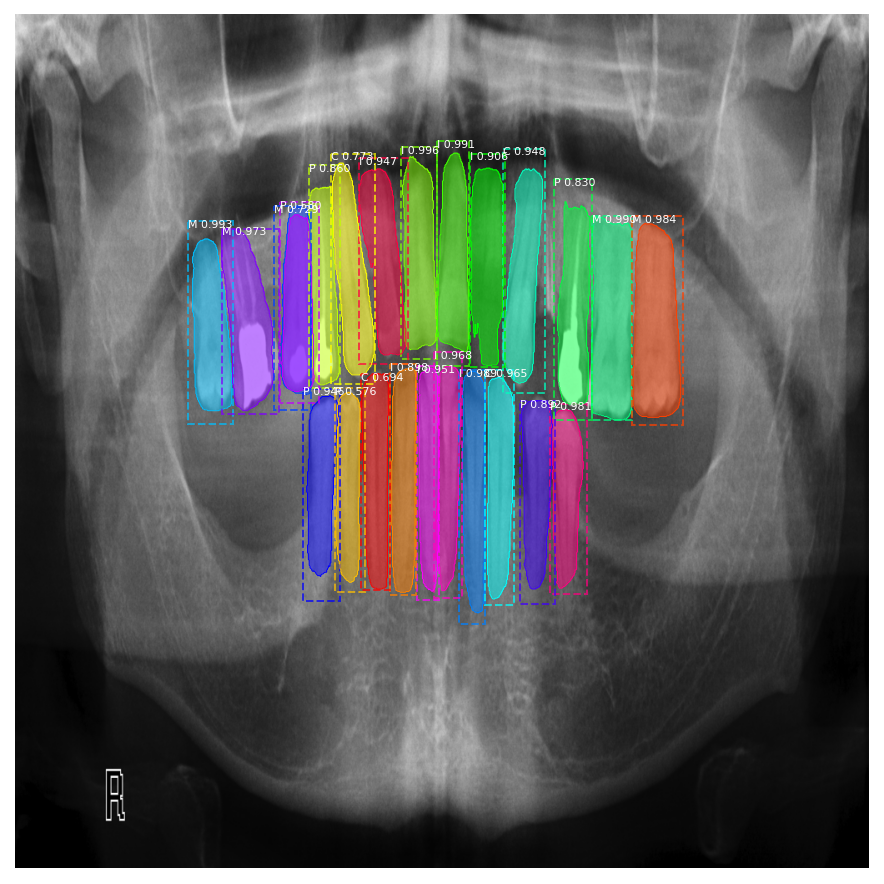

In [7]:
path_to_new_image = r'C:\Users\HP\Desktop\dental\DentalPanoramicXrays\boxed_images\10241024\5 class classification\dataset\val\6.png'
image1 = cv2.imread(path_to_new_image)
# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results


r = results1[0]
visualize.display_instances(image1, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'])
                            